# Table of contents 
- [Setup](#setup)
    - [Purpose](#purpose)
    - [Libraries](#libraries) 
- [NeuroImage](#neuroimage)
    - [Articles containing material URLs](#articlescontainingmaterialURLs)
    - [Popular URLs](#popularURLs)
    - [Popular domains](#populardomains)
    - [Deep dive: Human Connectome Projects](#deepdive_humanconnectomeprojects)
        - [URLs containing 'humanconnectome.org'](#URLscontaininghumanconnectome.org)
        - [Sentences](#sentences)
        - [HCPs reuse](#HCPsReuse)
            - [OpenAlex](#OpenAlex)
            - [HCP links in OpenAlex articles](#HCPlinksinopenalexarticles)
- [](#)
- [References](#references)

<a name='setup'></a>
# 0. Setup 

This notebook contains the code to investigate the extent of dataset reuse; specifically the reuse of the datasets used in the articles published in NeuroImage in 2022. 

<a name='purpose'></a>
## 0.1. Purpose 

The purpose of this notebook is to investigate how many other articles across articles available in OpenAlex use the same datasets as those used by the researchers who published their work in NeuroImage in 2022. 
This notebook draws on the work by Theó Sourget (2023a, 2023b), who similarly investigated the usage of a select couple of datasets. 

<a name='libraries'></a>
## 0.2. Libraries 

In [151]:
import pandas as pd 
import numpy as np 
import csv
import re
import json
import os
import ast 

import time
import requests
from requests.adapters import HTTPAdapter
from requests.adapters import Retry
from urllib3.util.retry import Retry

# Matplotlib for visualisations (Hunter 2007)
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
# Seaborn for visualizations (Waskom 2021) 
import seaborn as sns

In [2]:
# Reuse of the links: how many use each of the links in urls = pd.read_csv('../Data/material_URLs.csv')

In [58]:
# The filtered_articles_all_urls.csv have links like creativecommons.org removed 
articles_df = pd.read_csv('../Data/articles_filtered_urls.csv')
articles_dois = pd.read_csv('../Data/ElsevierAPI/articles_doi.csv')
material_urls = pd.read_csv('../Data/material_URLs.csv') # 305 unique cleaned material URLs (with https://, www., etc.)
classified_df = pd.read_csv('../Data/classified_data.csv') # 523 sentences with material URLs identified by the classifier 

In [59]:
articles_dois = articles_dois.rename(columns={"DOIs": "DOI"})
articles_dois['DOI'] = articles_dois['DOI'].str.replace('.pdf', '', regex=False)

In [60]:
unique_articles_dois_all = articles_df['DOI'].str.replace('/', '.')
unique_articles_dois_all = unique_articles_dois_all.unique()

In [61]:
print("Unique DOIs from NeuroImage: ", len(articles_df['DOI'].unique()))  # total number of unique DOIs in articles_df, includes editorial board
print("Unique DOIs from NeuroImage, excluding non-articles: ", np.sum(np.isin(unique_articles_dois_all, articles_dois['DOI'])))  # total number of unique DOIs in articles_df, excludes editorial board
print("Number of articles with URLs: ", len(classified_df['DOI'].unique()))  # total number of unique DOIs with URLs in classified_df
print("Number of articles with URLs classified as Material", len(classified_df[classified_df['Material'] == 1]['DOI'].unique()))  # number of unique DOIs with Material URLs

Unique DOIs from NeuroImage:  834
Unique DOIs from NeuroImage, excluding non-articles:  815
Number of articles with URLs:  693
Number of articles with URLs classified as Material 308


In [62]:
def clean_urls(urls):
    """Remove http://, https://, https://www., www. and trailing / or /)
    """
    cleaned_urls = urls.str.replace(r'^https?://(?:www\.)?|www\.|/$|/\)$', '', regex=True, flags=re.IGNORECASE)
    cleaned_urls = cleaned_urls.str.lower()
    return cleaned_urls

In [63]:
classified_df['URL'] = clean_urls(classified_df['URL'])

In [64]:
# Merge the two DataFrames on the condition that the URL contains any Material_URL as an exact match
merged_df = classified_df.merge(material_urls, how='inner', left_on='URL', right_on='Material_URL')

# Get the unique DOIs from the merged DataFrame
unique_dois = merged_df['DOI'].unique()

In [65]:
len(unique_dois)

355

# 1. NeuroImage 

searching: excluding what's in front of the link (i.e., www, https://), but being specific about the fact that it has to end the same way 

NeuroImage 
-  The most used material URL among NeuroImage
    - Is this material URL a specific dataset?
    - If it is a specific dataset - do some of the other URLs also contain the same data? (look through the validated URLs) 

General reuse 

But first: I clean the URLs in articles_df['URL'] the same way I cleaned the URL in 'Code/classifier_SciBERT.ipynb'

-  The most used material URLs among NeuroImage
    - Is this material URL a specific dataset?
    - If it is a specific dataset - do some of the other URLs also contain the same data? (look through the validated URLs) 

In [66]:
def clean_urls(urls):
    """Remove http://, https://, https://www., www. and trailing / or /). 
    Additionally, I will remove the words and characters found in 'Code/classifier_SciBERT.ipynb' and highlighted in 'Data/'URLs_validated_comments.csv'. 
    This includes the following trailing strings and characters: 
        - apply, the, and, data, supplementary, credit, 3 
        - *, ), (
        	- (under, (dataset, (Grootswagers
    """
    # Remove http://, https://, https://www., www. and trailing / or /)
    cleaned_urls = urls.str.replace(r'^https?://(?:www\.)?|www\.|/$|/\)$', '', regex=True, flags=re.IGNORECASE)

    # Lowercase the URLs
    cleaned_urls = cleaned_urls.str.lower()
    
    # Remove specific words and characters that made more than one URL invalid in 'classifier_SciBERT.ipynb'
    words_to_remove = ['the', 'and', ')', '(']
    for word in words_to_remove:
        cleaned_urls = cleaned_urls.str.replace(r'/{}\b$'.format(re.escape(word)), '', regex=True, flags=re.IGNORECASE)

    return cleaned_urls

A couple of the URLs were manually edited upon manually validating them ('Code/classifier_SciBERT.ipynb', section 3.1. Validate URLs). I will change the URLs that were replaced. 

In [67]:
# Clean the URLs 
articles_df['Clean URL'] = clean_urls(articles_df['URL'])

In [68]:
changed_urls = pd.read_csv('../Data/URLs_validated_comments.csv', delimiter=';', usecols=range(5)) 
changed_urls = changed_urls[changed_urls['Link that works'].notna()]

In [69]:
# Dictionary mapping original URLs to replacement values
url_replacement_dict = dict(zip(changed_urls['URL'], changed_urls['Link that works']))

# Replace URLs in articles_df['URL'] using the dictionary
articles_df['Clean URL'] = articles_df['Clean URL'].replace(url_replacement_dict)

# Clean the URLs again
articles_df['Clean URL'] = clean_urls(articles_df['Clean URL'])

In [70]:
# Make sure each clean URL only appears once per DOI
articles_df_unique = articles_df.drop_duplicates(subset=['Clean URL', 'DOI'])

In [71]:
print(len(articles_df))
print(len(articles_df_unique))

3002
2937


<a name='articlescontainingmaterialURLs'></a>
## 1.1. Articles containing material URLs

- Find out how many articles contain dataset URLs from material_urls
    - overview of articles in total that link to a dataset
    - overview of articles that link to one or more datasets 

In [94]:
len(classified_df[classified_df['Material']==1]['URL'].unique()) # there are 393 URLs classified as Material 
len(classified_df[classified_df['Material']==1]['DOI'].unique()) # there are 308 articles with Material URLs 

308

In [95]:
total_articles = np.sum(np.isin(unique_articles_dois_all, articles_dois['DOI'])) # 815 

# Articles with material URLs 
articles_with_material_urls = classified_df[classified_df['Material'] == 1]['DOI'].nunique() # 308

# Articles without material URLs - consists of articles with URLs and those without 
articles_without_material_urls_with_url = (classified_df['DOI'].nunique()) - articles_with_material_urls # 385 - 385+308 = 693 articles with URLs
articles_without_urls = total_articles - (classified_df['DOI'].nunique()) # 122 - 122+385+308 = 815 

articles_without_material_urls_total = articles_without_material_urls_with_url + articles_without_urls # 507 

# Percentages 
articles_with_material_urls_pct = round(articles_with_material_urls / total_articles * 100, 1)
articles_without_material_urls_with_url_pct = round(articles_without_material_urls_with_url / total_articles * 100, 1)
articles_without_urls_pct = round(articles_without_urls / total_articles * 100, 1)
articles_without_material_urls_total_pct = round(articles_without_material_urls_total / total_articles * 100, 1)

In [73]:
print(f"Total number of articles, excluding Editorial Board: {total_articles}")
print(f"Total number of articles with material URLs: {articles_with_material_urls}")
print(f"Total number of articles that contains URLs, just not material URLs: {articles_without_material_urls_with_url}")
print(f"Total number of articles that do not contain any URLs: {articles_without_urls}")
print(f"Total number of articles without material URLs: {articles_without_material_urls_total}")

Total number of articles, excluding Editorial Board: 815
Total number of articles with material URLs: 308
Total number of articles that contains URLs, just not material URLs: 385
Total number of articles that do not contain any URLs: 122
Total number of articles without material URLs: 507


In [96]:
print(articles_with_material_urls_pct)
print(articles_without_material_urls_with_url_pct)
print(articles_without_urls_pct)
print(articles_without_material_urls_total_pct)

37.8
47.2
15.0
62.2


The numbers above match the numbers and figures from classifier_SciBERT_v2.ipynb - there are 308 (37.8%) articles with material URLs, and 507 (62.2%) articles without material URLs - the majority of the articles without material URLs do contain URls. 

In [97]:
material_counts = classified_df[classified_df['Material'] == 1].groupby('DOI').size().reset_index(name='material_count')
material_counts['DOI'] = material_counts['DOI'].str.replace('/', '.')

all_dois = articles_dois['DOI'].tolist()

missing_dois = set(all_dois) - set(material_counts['DOI'])
missing_counts = pd.DataFrame({'DOI': list(missing_dois), 'material_count': 0})
material_counts = pd.concat([material_counts, missing_counts], ignore_index=True)

# Create a column indicating if the article has material URLs
material_counts['Has_Material_URL'] = material_counts['material_count'] > 0

total_articles = len(articles_dois)
articles_with_material_url_alt = len(material_counts[material_counts['Has_Material_URL']==True])
articles_without_material_url_alt = total_articles - articles_with_material_url_alt

In [98]:
material_counts

,DOI,material_count,Has_Material_URL
0,10.1016.j.neuroimage.2021.118698,1,True
1,10.1016.j.neuroimage.2021.118718,1,True
2,10.1016.j.neuroimage.2021.118739,3,True
3,10.1016.j.neuroimage.2021.118748,1,True
4,10.1016.j.neuroimage.2021.118751,1,True
5,10.1016.j.neuroimage.2021.118756,2,True
6,10.1016.j.neuroimage.2021.118760,1,True
7,10.1016.j.neuroimage.2021.118770,1,True
8,10.1016.j.neuroimage.2021.118774,1,True
9,10.1016.j.neuroimage.2021.118775,3,True


In [100]:
articles_without_material_url_alt # same as articles_without_material_url - it still adds up 

507

In [101]:
articles_with_material_url_alt # articles_with_material_url - it still adds up 

308

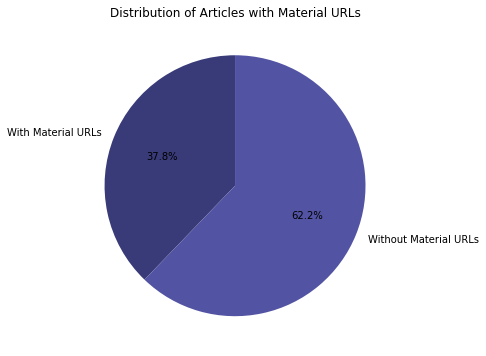

In [103]:
# Create a pie chart showing the distribution of articles with and without material URLs
plt.figure(figsize=(10, 6))
plt.pie([len(material_counts[material_counts['Has_Material_URL']]), articles_without_material_url_alt], labels=['With Material URLs', 'Without Material URLs'],
        autopct='%1.1f%%', startangle=90, colors=plt.cm.tab20b.colors)
plt.title('Distribution of Articles with Material URLs')
#plt.savefig('../Results/graphics/NeuroImage_ArticlesWithMaterialURLs_alt.png')
plt.show()

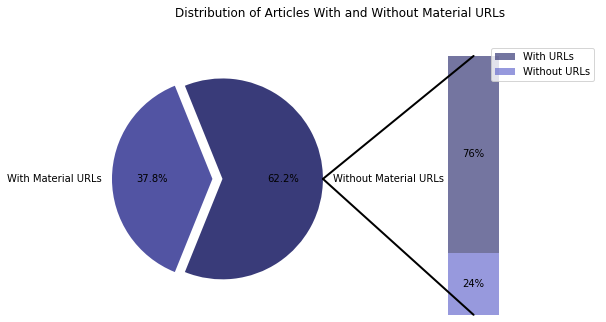

In [104]:
# Create a pie chart showing the distribution of articles with and without material URLs
pie_labels = ['Without Material URLs', 'With Material URLs']
pie_sizes = [articles_without_material_urls_total, articles_with_material_urls]

# Create a bar chart showing the distribution of articles with and without URLs
bar_labels = ['Without URLs', 'With URLs']
bar_ratios = [articles_without_urls / sum([articles_without_urls, articles_without_material_urls_with_url]),
              articles_without_material_urls_with_url / sum([articles_without_urls, articles_without_material_urls_with_url])]

# Make figure and assign axis objects
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))
fig.subplots_adjust(wspace=0)

fig.suptitle('Distribution of Articles With and Without Material URLs')

# Pie chart parameters
overall_ratios = [size / sum(pie_sizes) for size in pie_sizes]
explode = [0, 0.1]

# Rotate so that the first wedge is split by the x-axis
angle = -180 * overall_ratios[0]
wedges, *_ = ax1.pie(overall_ratios, autopct='%1.1f%%', startangle=angle,
                     labels=pie_labels, explode=explode, colors=plt.cm.tab20b.colors)

# Bar chart parameters
width = .2
bottom = 1

# Adding from the top matches the legend.
for j, (ratio, label) in enumerate(reversed([*zip(bar_ratios, bar_labels)])):
    bottom -= ratio
    bc = ax2.bar(0, ratio, width, bottom=bottom, color=plt.cm.tab20b(j * 2), label=label, alpha=0.7)
    ax2.bar_label(bc, labels=[f"{ratio:.0%}"], label_type='center')

ax2.legend()
ax2.axis('off')
ax2.set_xlim(-2.5 * width, 2.5 * width)

# Use ConnectionPatch to draw lines between the two plots
theta1, theta2 = wedges[0].theta1, wedges[0].theta2
center, r = wedges[0].center, wedges[0].r
bar_height = sum(bar_ratios)

# Draw connecting line to the middle of the bottom of the bar chart
x_bottom = r * np.cos(np.pi / 180 * (theta1 + theta2) / 2) + center[0]
y_bottom = r * np.sin(np.pi / 180 * (theta1 + theta2) / 2) + center[1]
con_bottom = ConnectionPatch(xyA=(0, 0), coordsA=ax2.transData,
                             xyB=(x_bottom, y_bottom), coordsB=ax1.transData)
con_bottom.set_color([0, 0, 0])
con_bottom.set_linewidth(2)
ax2.add_artist(con_bottom)

# Draw connecting line to the middle of the top of the bar chart
x_top = r * np.cos(np.pi / 180 * (theta1 + theta2) / 2) + center[0]
y_top = r * np.sin(np.pi / 180 * (theta1 + theta2) / 2) + center[1] 
con_top = ConnectionPatch(xyA=(0, bar_height), coordsA=ax2.transData,
                          xyB=(x_top, y_top), coordsB=ax1.transData)
con_top.set_color([0, 0, 0])
con_top.set_linewidth(2)
ax2.add_artist(con_top)

plt.savefig('../Results/graphics/NeuroImage_ArticlesWithMaterialURLs.png')
plt.show()

In [130]:
len(material_counts[material_counts['material_count'] == 1])

193

In [132]:
len(material_counts[material_counts['material_count'] > 1])

115

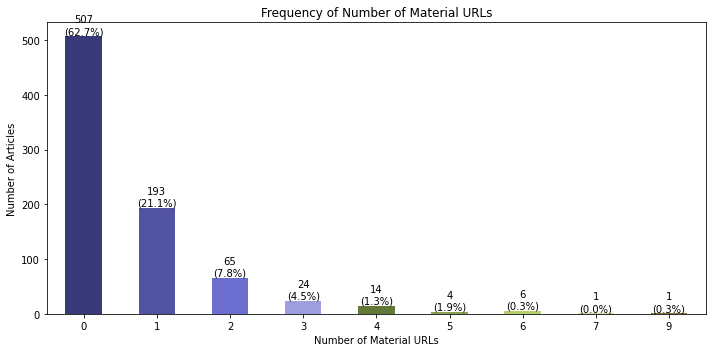

In [135]:
# Calculate the percentage for each bar
total_articles = material_counts['Has_Material_URL'].sum()
percentage = material_counts[material_counts['Has_Material_URL']]['material_count'].value_counts(normalize=True).sort_index() * 100

# Create a bar plot showing the frequency of articles with material URLs
plt.figure(figsize=(10, 5))
ax = material_counts['material_count'].value_counts().sort_index().plot(kind='bar', color=plt.cm.tab20b.colors)
plt.title('Frequency of Number of Material URLs')
plt.xlabel('Number of Material URLs')
plt.ylabel('Number of Articles')
plt.xticks(rotation=0)

# Annotate each bar with its count and percentage, move numbers a bit more up
for i, v in enumerate(material_counts['material_count'].value_counts().sort_index()):
    percentage_value = percentage.get(i + 1, 0)
    ax.text(i, v + 0.05, f"{v}\n({percentage_value:.1f}%)", color='black', ha='center', va='bottom')  # Adjusted vertical alignment

# Save the plot and display it
plt.tight_layout()
plt.savefig('../Results/graphics/NeuroImage_NumberOfMaterialURLs.png')
plt.show()

<a name='popularURLs'></a>
## 1.2. Popular URLs 

In [272]:
# Count the occurrences of each unique cleaned URL in articles_df
neuroimage_url_counts = articles_df_unique['Clean URL'].value_counts() 

# Check how many times each URL from material_urls appears in articles_df and calculate percentage 
material_urls['Number of articles containing URL'] = material_urls['Material_URL'].map(neuroimage_url_counts)
material_urls['Percentage of articles containing URL'] = round((material_urls['Number of articles containing URL'] / articles_with_material_urls) * 100,1)

# Sort material_urls by count in descending order
material_urls_sorted = material_urls.sort_values(by='Number of articles containing URL', ascending=False)
material_urls_sorted.to_csv('../Results/tables/NeuroImage2022_materialURLs_counts.csv', index=False)

In [270]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

In [273]:
material_urls_sorted

,Material_URL,Number of articles containing URL,Percentage of articles containing URL
292,surfer.nmr.mgh.harvard.edu,48,15.6
115,humanconnectome.org,28,9.1
51,db.humanconnectome.org,22,7.1
36,clinicaltrials.gov,20,6.5
1,adni.loni.usc.edu,17,5.5
163,neurosynth.org,12,3.9
121,humanconnectome.org/study/hcp-young-adult,12,3.9
124,humanconnectome.org/study/hcp-young-adult/document/1200-subjects-data-release,10,3.2
304,ﬁl.ion.ucl.ac.uk,9,2.9
0,abcdstudy.org,8,2.6


In [274]:
material_urls_sorted[material_urls_sorted['Number of articles containing URL'].isna()]

,Material_URL,Number of articles containing URL,Percentage of articles containing URL


In [275]:
# Assuming 'Count in articles' is the column in material_urls_sorted representing the count
count_statistics = material_urls_sorted['Number of articles containing URL'].describe()
count_statistics.to_csv('../Results/tables/NeuroImage2022_materialURLs_summaryStats.csv')

# Print the summary statistics
print(round(count_statistics, 1))

count    305.0
mean       1.9
std        3.8
min        1.0
25%        1.0
50%        1.0
75%        1.0
max       48.0
Name: Number of articles containing URL, dtype: float64


I want to know how many of the URLs are (re)used. 

In [276]:
len(material_urls_sorted) # URLs in total 

305

In [277]:
len(material_urls_sorted[material_urls_sorted['Number of articles containing URL'] == 1]) # URLs referenced once 

246

In [278]:
len(material_urls_sorted[material_urls_sorted['Number of articles containing URL'] > 1]) # URLs referenced more than once

59

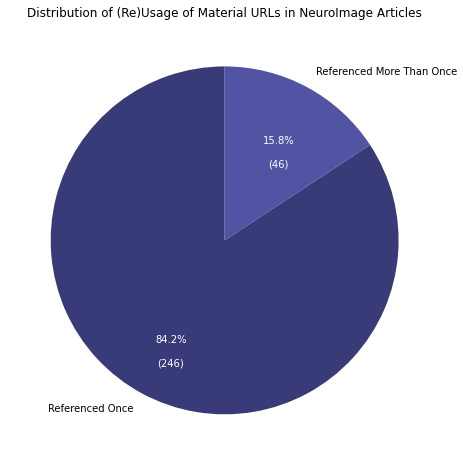

In [147]:
# Count the occurrences of each number
count_distribution = material_urls_sorted['Number of articles containing URL'].value_counts()

# Extract the counts for URLs referenced once and more than once
urls_referenced_once = count_distribution.get(1, 0)
urls_referenced_more_than_once = count_distribution.get(2, 0) + count_distribution.get(3, 0) + count_distribution.get(4, 0)  # Add more if needed

# Create a pie chart
labels = ['Referenced Once', 'Referenced More Than Once']
sizes = [urls_referenced_once, urls_referenced_more_than_once]
colors = plt.cm.tab20b.colors

fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90, textprops={'color': 'white'})
ax.set_title('Distribution of (Re)Usage of Material URLs in NeuroImage Articles')

# Add count in parenthesis within the slice
for wedge, text, autotext, size in zip(wedges, texts, autotexts, sizes):
    text.set_color('black')  # Set text color to white
    autotext.set_color('white')  # Set autotext color to white

    # Adjust the position of the percentage and count within the slice
    theta = wedge.theta1 + (wedge.theta2 - wedge.theta1) / 2.0
    r = 1.3 * wedge.r
    x = r * 0.5 * plt.np.cos(plt.np.radians(theta))
    y = r * 0.5 * plt.np.sin(plt.np.radians(theta))
    
    autotext.set_position((x, y))  # Adjust the position of the percentage
    ax.text(x, y - 0.15, f'({size})', color='white', ha='center')  # Add count in parentheses

# Save the plot and display it
plt.savefig('../Results/graphics/NeuroImage_MaterialURLs_Reused_Distribution.png')
plt.show()

In [279]:
# Get the top fifteen most mentioned URLs
top_fifteen_urls = material_urls_sorted.head(15)
top_fifteen_urls.to_csv('../Results/tables/NeuroImage2022_materialURLs_top15.csv', index=False)

In [280]:
top_fifteen_urls

,Material_URL,Number of articles containing URL,Percentage of articles containing URL
292,surfer.nmr.mgh.harvard.edu,48,15.6
115,humanconnectome.org,28,9.1
51,db.humanconnectome.org,22,7.1
36,clinicaltrials.gov,20,6.5
1,adni.loni.usc.edu,17,5.5
163,neurosynth.org,12,3.9
121,humanconnectome.org/study/hcp-young-adult,12,3.9
124,humanconnectome.org/study/hcp-young-adult/document/1200-subjects-data-release,10,3.2
304,ﬁl.ion.ucl.ac.uk,9,2.9
0,abcdstudy.org,8,2.6


- surfer.nmr.mgh.harvard.edu: This is actually not a dataset but an open-source toolkit for processing, analyzing, and visualizing brain images. This URL was falsely classified as Material. 
- humanconnectome.org: This website contains multiple datasets, so it's possible that the links were cut short or that the specific dataset was mentioned in the text.
- db.humanconnectome.org: This website is a data management platform where users can access the datasets from the Human Connectome Project, i.e., the same datasets as the link before. You need a login.
- clinicaltrials.gov: The website contains multiple datasets, so it's possible that the links were cut short or that the specific dataset or search conditions were mentioned in the text. 
- adni.loni.usc.edu: This website contains multiple datasets, including the ADNI data, DoD-ADNI data, and the AIBL data. 
- neurosynth.org: This website is a database containing 14371 studies and maps for over 150,000 brain locations. 
- humanconnectome.org/study/hcp-young-adult: This is a dataset; there are two available releases following this link. 
- humanconnectome.org/study/hcp-young-adult/document/1200-subjects-data-release: This is the documentation of a specific dataset on how to use it. 
- fil.ion.ucl.ac.uk: This is the website for a laboratory associated with an institution of neurology - they offer access to a couple of different datasets on a subsection on their website (https://www.fil.ion.ucl.ac.uk/spm/data/). As this website contains multiple datasets, it's possible that the links were cut short or that the specific dataset was mentioned in the text. 
- abcdstudy.org: This is the website for a research consortium involving 21 research sites across the US. They offer access to the most recent version of their dataset (they link it on a subsite, https://abcdstudy.org/scientists/data-sharing/, that points to a website external of abcdstudy.org, https://nda.nih.gov/study.html?id=2147). The exact dataset is hosted on another website and multiple versions have been published, so it's possible that this dataset was referred to using other links. 
- brain-development.org/ixi-dataset: This website contains 600 MR images using different image acquisition protocols from normal, healthy subjects collected at three hospitals. 
- coins.trendscenter.org: This website is a data management system that provides an interface for data collection, managing, and sharing. The website contains a 'Data Exchange', where datasets like The Autism Brain Imaging Data Exchange (ABIDE), The Center for Biomedical Research Excellence (COBRE), Consortium for Reliability and Reproducibility (CoRR), The Enhanced NKI Rockland Sample, and The MIND Clinical Imaging Consortium have been shared. As this website contains multiple datasets, it's possible that the links were cut short or that the specific dataset were mentioned in the text. 
- itksnap.org/pmwiki/pmwiki.php: This is actually not a dataset but an open-source software application to segment structures in 3D and 3D biomedical images. This URL was falsely classified as Material. 
- openneuro.org: This website contains multiple datasets, so it's possible that the links were cut short or that the specific dataset was mentioned in the text.
- human.brain-map.org: This website contains multiple datasets, including microarray datasets of six brains, RNA-sequencing datasets, and archived microarray datasets. It's possible that the links were cut short or that the specific dataset was mentioned in the text.

<a name='populardomains'></a>
## 1.3. Popular domains 
From the list of material URLs, I want to investigate which domains are common to see if there is a tendency for the datasets to be hosted on certain websites. 

In [281]:
def find_domains_and_subdomains(urls):
    """ 
    This function finds domains and subdomains, 
    removing the beginning (https:// or wwww) and puts all text into lowercase. 
    Parameters: 
    :param urls(list): Sorted list of unique URLs from a dataframe
    """    
    # Remove "https://", "http://", and "www." from the URLs
    clean_urls = [url.replace("https://", "").replace("http://", "").replace("www.", "").lower() for url in urls]
    
    url_dict = {}
    for url in clean_urls:
        root = url.split('/')[0]
        # root = '/'.join(url.split('/'))
        if root in url_dict:
            url_dict[root].append(url)
        else:
            url_dict[root] = [url]

    grouped_df = pd.DataFrame(url_dict.items(), columns=['Domain', 'Subdomain']).sort_values('Domain', ascending=True)

    return grouped_df

In [283]:
# material_urls # Number of articles containing URL

In [284]:
domains_subdomains = find_domains_and_subdomains(material_urls['Material_URL'])

In [285]:
domains_subdomains

,Domain,Subdomain
0,abcdstudy.org,[abcdstudy.org]
1,adni.loni.usc.edu,"[adni.loni.usc.edu, adni.loni.usc.edu/about, adni.loni.usc.edu/data-samples/access-data, adni.loni.usc.edu/methods/pet-analysis-method/pet-analysis]"
2,aibl.org.au,[aibl.org.au]
3,atlas.brain-map.org,[atlas.brain-map.org]
4,ausnc.org.au,[ausnc.org.au/corpora/ice)]
5,balsa.wustl.edu,"[balsa.wustl.edu, balsa.wustl.edu/study/7, balsa.wustl.edu/study/7qmqx, balsa.wustl.edu/study/show/mdbp0]"
6,bicr-resource.atr.jp,[bicr-resource.atr.jp/srpbsts]
7,bids.neuroimaging.io,[bids.neuroimaging.io]
8,bigbrain.loris.ca,[bigbrain.loris.ca]
9,biobank.ctsu.ox.ac.uk,[biobank.ctsu.ox.ac.uk]


In [292]:
result_df = pd.DataFrame(columns=['Domain', 'Number of articles containing URL'])

for index, row in domains_subdomains.iterrows():
    matching_rows = material_urls[material_urls['Material_URL'].isin(row['Subdomain'])]
    total_count = matching_rows['Number of articles containing URL'].sum()
    percentage = round((total_count / articles_with_material_urls) * 100,1)
    
    result_df = pd.concat([result_df, pd.DataFrame({
        'Domain': [row['Domain']],
        'Number of articles containing URL': [total_count],
        'Percentage of articles containing URL': [percentage]
    })], ignore_index=True)

result_df_sorted = result_df.sort_values(by='Percentage of articles containing URL', ascending=False)
result_df_sorted.to_csv('../Results/tables/NeuroImage2022_materialURLsDomainsSubdomains_counts.csv', index=False)

# Save the top 15 domains to a separate CSV file
result_df_top15 = result_df_sorted.head(15)
result_df_top15.to_csv('../Results/tables/NeuroImage2022_materialURLsDomainsSubdomains_top15.csv', index=False)

In [293]:
result_df_top15

,Domain,Number of articles containing URL,Percentage of articles containing URL
100,osf.io,73,23.7
62,humanconnectome.org,60,19.5
120,surfer.nmr.mgh.harvard.edu,48,15.6
56,github.com,34,11.0
1,adni.loni.usc.edu,22,7.1
40,db.humanconnectome.org,22,7.1
27,clinicaltrials.gov,20,6.5
99,openneuro.org,17,5.5
50,fcon_1000.projects.nitrc.org,16,5.2
91,neurosynth.org,12,3.9


<a name='deepdive_humanconnectomeproject'></a>
## 1.4. Deep dive: Human Connectome Project 
Among the top 15 most cited material URLs, a couple of them refer to one or more of the Human Connectome Projects, including *humanconnectome.org*, *db.humanconnectome.org*, *humanconnectome.org/study/hcp-young-adult*, *humanconnectome.org/study/hcp-young-adult/document/1200-subjects-data-release*. Outside the top most referenced URLs there are more links that refer to HCP, 

And some of the other URLs also contain the data. 

<a name='URLscontaininghumanconnectome.org'></a>
### 1.4.1. URLs containing 'humanconnectome.org'
I investigate all URLs that contain 'humanconnectome.org' among the URLs that were classified as material and validated to work. 

In [31]:
df = pd.read_csv('../Results/NeuroImage2022_materialURLs_counts.csv') # variable "material_urls_sorted" from earlier 
HCP_urls = df[df['Material_URL'].str.contains('humanconnectome.org', na=False)]
HCP_urls = HCP_urls.rename(columns={"Count in articles": "NeuroImage articles"})
HCP_urls.to_csv('../Results/HCPs/HCPs_urls.csv', index=False)

In [32]:
len(HCP_urls)

15

In [33]:
HCPs = pd.read_csv('../Results/HCPs/HCPs_urls.csv')

In [34]:
HCPs

,Material_URL,NeuroImage articles
0,humanconnectome.org,28
1,db.humanconnectome.org,22
2,humanconnectome.org/study/hcp-young-adult,12
3,humanconnectome.org/study/hcp-young-adult/document/1200-subjects-data-release,10
4,humanconnectome.org/study/hcp-young-adult/data-use-terms,2
5,protocols.humanconnectome.org/hcp/7t,1
6,wiki.humanconnectome.org/display/publicdata/how+to+connect+to+connectome+data+via+aws,1
7,humanconnectome.org/data,1
8,humanconnectome.org/disease-studies,1
9,humanconnectome.org/study/hcp-lifespan-aging,1


<a name='sentences'></a>
### 1.3.2. Sentences 
Sentences containing URLs that contain 'humanconnectome.org'

In [35]:
#articles_df_unique[articles_df_unique['Clean URL']=='humanconnectome.org']['Sentences']

In [196]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [247]:
pd.reset_option('display.max_columns')
pd.reset_option('display.max_rows')
pd.reset_option('display.max_colwidth')

In [239]:
most_cited = HCPs['Material_URL'].loc[:1].tolist()

In [240]:
most_cited

['humanconnectome.org', 'db.humanconnectome.org']

In [249]:
articles_df_unique['Sentences'].loc[1]

"['The cohort data is accessible through the website (https://coins.trendscenter.org/) of COINS (COllaborative Infor-matics Neuroimaging Suite) database (Scott et al., 2011).']"

In [250]:
# Filter rows where Clean URL is 'humanconnectome.org' or 'db.humanconnectome.org' and retain the DOI and sentences containing either of those links 
dfs = []

for index, row in articles_df_unique.iterrows():
    doi = row['DOI']
    sentences_str = row['Sentences']
    
    try:
        sentences_list = ast.literal_eval(sentences_str)
    except (SyntaxError, ValueError):
        sentences_list = []
    
    if any(match == row['Clean URL'] for match in most_cited):
        # Flatten the list of sentences and concatenate into a single string
        flat_sentences = ' '.join(sentences_list) if isinstance(sentences_list, list) else sentences_list
        article_df = pd.DataFrame({"DOI": [doi], "Sentences": [flat_sentences]})
        dfs.append(article_df)

result_df = pd.concat(dfs, ignore_index=True)
result_df.to_csv('../Results/HCPs/humanconnectome.org_sentences.csv', index=False)

In [251]:
result_df

,DOI,Sentences
0,10.1016/j.neuroimage.2022.119550,Data and code availability All data used in th...
1,10.1016/j.neuroimage.2022.119550,All HCP data may be downloaded through the Con...
2,10.1016/j.neuroimage.2022.119339,humanconnectome.org/and https://www.developing...
3,10.1016/j.neuroimage.2022.118972,humanconnectome.org/The tool we used for analy...
4,10.1016/j.neuroimage.2022.119742,Data and code availability statement The data ...
5,10.1016/j.neuroimage.2022.118907,All Human Connectome Project resting-state dat...
6,10.1016/j.neuroimage.2022.119569,The unrestricted and restricted phenotype data...
7,10.1016/j.neuroimage.2022.119193,Data and Code Availability Statement The data ...
8,10.1016/j.neuroimage.2022.118930,Data and code availability All imaging data us...
9,10.1016/j.neuroimage.2022.119433,A complete description of the acquisition and ...


Very few of the sentences [8/68] mention which specific HCP dataset they used. Of the mentions, most use the Healthy Adult Connectomes. 
- humanconnectome.org) from the Washington University-University of Minnesota (WUMinn) consortium, including 484 healthy participants from the Q4 release (500 subject; Nov 25, 2014; 272 females, 212 males; age = 29.15 ± 3.47).
- In the present study, we utilized a publicly available dataset, provided by the Human Connectome Project (HCP; http://www.humanconnectome.org) from the Washington University-University of Minnesota (WU-Minn) consortium, including 484 healthy participants from the Q4 release (500 subject; Nov 25, 2014).
- Primary dataset (HCP) Structural, diﬀusion and resting-state functional MRI data of 210 healthy subjects (males = 92, females = 118, age range 22-36 years) were retrieved from the HCP repository (https://humanconnectome.org).
- We obtained behavioral and neuroimaging data of 495 ran-domly selected subjects from the Human Connectome Project (HCP; www.humanconnectome.org), an open-access database aimed at col-lecting healthy participant data from over 1200 people. 
- Behavioral and neuroimaging data for this manuscript was obtained from the Human Connectome Project (HCP; www.humanconnectome.org), an open-access database aimed at collecting healthy participant data from over 1200 people.
- The signal time course was originally from the WU-Minn HCP young healthy adults (ages 22–35) S1200 release data (https://www.humanconnectome.org/study/hcp-young-adult).
- The healthy subjects’ data used in this study are openly available at https://www.humanconnectome.org/.
- For application to real-world data, we obtained resting-state fMRI data from the HCP1200 release from the Human Connectome Project (Essen et al., 2013) (https://www.humanconnectome.org).

There are a couple of sentences [4/68] that should not have been included for this URL: 
- [False hit for humanconnectome.org] This data is publicly available to researchers who agree to the data use terms (www.humanconnectome.org/study/hcp-young-adult/data-use-terms).
- [False hit for humanconnectome.org] Further details of the 7T rs-fMRI acquisition protocols are given in the HCP reference manual (https://humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf).
- [False hit for humanconnectome.org] To this purpose, we employed the Con-nectome Workbench software (version 1.2.3; retrieved November 30, 2020 from https://www.humanconnectome.org/software/connectome-workbench ; Marcus et al., 2011).
- [False hit for humanconnectome.org] Both preprocessed and unpreprocessed neonatal and adult data can be freely accessed via registration to the Developing Human Connec-tome Project (dHCP); http://www.developingconnectome.org/project/and Human Connectome Project (HCP) Young Adult Database (https://www.humanconnectome.org/study/hcp-young-adult).

<a name='HCPsReuse'></a>
### 1.3.4. HCPs Reuse 

You can use the search query parameters to search for various search terms across titles, abstracts, and full text (if the text has the full text available). 
I need to use the fulltext.search OpenAlexAPI (Filter works). 

This was all run on December 2nd, 2023. 

References: 
- OpenAlexAPI. (n.d.-a). Filter works. OpenAlex API Documentation. Retrieved September 14, 2023, from https://docs.openalex.org/api-entities/works/filter-works
- OpenAlexAPI. (n.d.). Search Works. Retrieved November 23, 2023, from https://docs.openalex.org/api-entities/works/search-works

<a name='OpenAlex'></a>
#### 1.3.4.1. OpenAlex 

In [38]:
OpenAlexWorks_total = requests.get(f'https://api.openalex.org/works').json()
OpenAlexWorks_total_count = OpenAlexWorks_total['meta']['count']

In [39]:
OpenAlexWorks_fulltext = requests.get(f'https://api.openalex.org/works?filter=has_fulltext:True').json()
OpenAlexWorks_fulltext_count = OpenAlexWorks_fulltext['meta']['count']

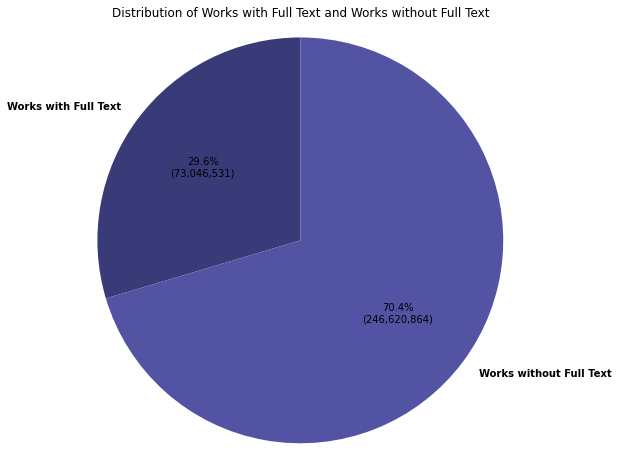

In [40]:
# Calculate the percentage
percentage = (OpenAlexWorks_fulltext_count / OpenAlexWorks_total_count) * 100

# Create data for the pie chart
labels = ['Works with Full Text', 'Works without Full Text']
sizes = [OpenAlexWorks_fulltext_count, OpenAlexWorks_total_count - OpenAlexWorks_fulltext_count]
colors = plt.cm.tab20b.colors[:2]  # Use only the first two colors from tab20b colormap

# Set a larger figure size
fig1, ax1 = plt.subplots(figsize=(8, 8))

# Plot the pie chart
patches, texts, autotexts = ax1.pie(sizes, labels=labels, autopct=lambda p: f'{p:.1f}%', startangle=90, colors=colors)

# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')

# Add percentages and raw counts under the circle
for i, (text, autotext) in enumerate(zip(texts, autotexts)):
    text.set(size=10, weight='bold')
    autotext.set(size=10, weight='normal')
    # Place raw count above the percentage
    if i == 0:
        autotext.set_text(f'{autotext.get_text()}\n({OpenAlexWorks_fulltext_count:,})')
    elif i == 1:
        autotext.set_text(f'{autotext.get_text()}\n({OpenAlexWorks_total_count:,})')

# Set title
plt.title('Distribution of Works with Full Text and Works without Full Text')
plt.savefig('../Results/graphics/OpenAlex_TotalWorksWithFullTextDistribution.png')

plt.show()

<a name='HCPlinksinopenalexarticles'></a>
#### 1.3.4.2. HCP links in OpenAlex articles 

In [41]:
def make_session():
    """Create and return a session object for making HTTP requests.
    """
    session = requests.Session()
    retries = Retry(total=5, backoff_factor=1, status_forcelist=[500, 502, 503, 504])
    session.mount('http://', HTTPAdapter(max_retries=retries))
    session.mount('https://', HTTPAdapter(max_retries=retries))
    return session

def fetch_unique_results(url, session):
    """Fetch information about articles from OpenAlex API using pagination for a given URL.
    """
    all_results = []
    processed_dois = set()
    url_prefixes = ['', 'https://', 'https://www.', 'http://', 'http://www.', 'www.']

    for prefix in url_prefixes:
        current_url = f'{prefix}{url}'
        page = 1 
        cursor = "*"

        while cursor is not None: 
            api_url = f'https://api.openalex.org/works?filter=fulltext.search:{current_url}&per_page=50&cursor={cursor}'
            response = session.get(api_url)
            if response.status_code == 200:
                data = response.json()
                articles_on_page = data.get("results", [])

                if not articles_on_page: 
                    break
                
                for result in articles_on_page:
                    doi = result.get('doi', '')
                    if doi in processed_dois:
                        continue
                    all_results.append(result)
                    processed_dois.add(doi)
                
                # Update the cursor for the next iteration
                cursor = data.get("meta", {}).get("next_cursor")
                
                page += 1
                time.sleep(0.1)  # Introduce a delay to comply with rate limits
            
            elif response.status_code == 403:
                print("Error fetching data. Status code:", response.status_code)
                print("Waiting and retrying...")
                time.sleep(60)  # Wait for a minute before retrying
            
            else:
                print("Error fetching data. Status code:", response.status_code)
                if response.status_code == 429:
                    # Exponential backoff in case of rate limiting (status code 429)
                    delay = 2 ** (page - 1)
                    time.sleep(delay)
                    print(f"Retrying after {delay} seconds...")
                else:
                    break

    return all_results

def process_material_urls(material_urls):
    """Process material URLs, fetches information about articles, and checks for statistical terms.
    """
    session = make_session()
    for material_url in material_urls:
        articles_info = fetch_unique_results(material_url, session)
        
        if not articles_info:
            print(f"For material URL {material_url}: No articles found.")
            continue

        # Check statistical terms in each article and update the information
        #for article_info in articles_info:
            #contains_statistical_terms = check_statistical_terms(article_info['id'], session)
            #article_info['contains_statistical_terms'] = contains_statistical_terms
        
        # Save the information to a JSON file
        combined_save_path = f'../Results/HCPs/MaterialURLReuse/{material_url.replace("/", "_")}.json'
        with open(combined_save_path, 'w') as combined_json_file:
            json.dump(articles_info, combined_json_file, indent=2)

        # Calculate and print statistics
        print(f"For material URL {material_url}:")
        print(f"Number of articles: {len(articles_info)}")
        #print(f"Number of articles containing statistical terms: {sum(article['contains_statistical_terms'] for article in articles_info)}")
        print("=" * 50)

In [42]:
# See how many times the HCPs URLs have been mentioned in other articles 
hcp_urls = HCPs['Material_URL']

In [206]:
# This took around 3 hours with 34 HCPs
process_material_urls(hcp_urls)

For material URL humanconnectome.org:
Number of articles: 847
For material URL db.humanconnectome.org:
Number of articles: 200
For material URL humanconnectome.org/study/hcp-young-adult:
Number of articles: 270
For material URL humanconnectome.org/study/hcp-young-adult/document/1200-subjects-data-release:
Number of articles: 42
For material URL humanconnectome.org/study/hcp-young-adult/data-use-terms:
Number of articles: 134
For material URL protocols.humanconnectome.org/hcp/7t:
Number of articles: 5
For material URL wiki.humanconnectome.org/display/publicdata/how+to+connect+to+connectome+data+via+aws: No articles found.
For material URL humanconnectome.org/data:
Number of articles: 804
For material URL humanconnectome.org/disease-studies:
Number of articles: 428
For material URL humanconnectome.org/study/hcp-lifespan-aging:
Number of articles: 88
For material URL humanconnectome.org/study/hcp-lifespan-aging/data-releases:
Number of articles: 58
For material URL humanconnectome.org/stu

The articles from OpenAlex that contain the humanconnectome.org URLs are in separate files per URL: ../Results/HCPs/MaterialURLReuse/db.humanconnectome.org.json.

For each of the URLs (in Results/HCPs/sorted_HCPs_urls.csv), I want to know how many other of OpenAlex' articles contain these links. 

In [152]:
HCPs = pd.read_csv('../Results/HCPs/HCPs_urls.csv')
HCPs_urls = HCPs['Material_URL'].tolist()

json_directory = '../Results/HCPs/MaterialURLReuse/'
url_counts = {}

# Iterate over each URL
for url in HCPs_urls:
    json_file_path = os.path.join(json_directory, f'{url.replace("/", "_")}.json')
    if os.path.exists(json_file_path):
        json_df = pd.read_json(json_file_path)
        url_counts[url] = len(json_df)
    else:
        url_counts[url] = 0

In [153]:
# Create a DataFrame from the dictionary
reusedURLs_count = pd.DataFrame(list(url_counts.items()), columns=['Material_URL', 'OpenAlex articles'])
reusedURLs_count = reusedURLs_count.sort_values(by='OpenAlex articles', ascending=False)

In [154]:
merged_df = pd.merge(HCPs, reusedURLs_count, on='Material_URL', how='left')

In [155]:
merged_df

,Material_URL,NeuroImage articles,OpenAlex articles
0,humanconnectome.org,28,847
1,db.humanconnectome.org,22,200
2,humanconnectome.org/study/hcp-young-adult,12,270
3,humanconnectome.org/study/hcp-young-adult/document/1200-subjects-data-release,10,42
4,humanconnectome.org/study/hcp-young-adult/data-use-terms,2,134
5,protocols.humanconnectome.org/hcp/7t,1,5
6,wiki.humanconnectome.org/display/publicdata/how+to+connect+to+connectome+data+via+aws,1,0
7,humanconnectome.org/data,1,804
8,humanconnectome.org/disease-studies,1,428
9,humanconnectome.org/study/hcp-lifespan-aging,1,88


In [156]:
json_directory = '../Results/HCPs/MaterialURLReuse/'
all_data = []

# Iterate over each JSON file
for filename in os.listdir(json_directory):
    if filename.endswith('.json'):
        json_file_path = os.path.join(json_directory, filename)
        json_df = pd.read_json(json_file_path, orient='records')
        all_data.append(json_df)

# Concatenate all DataFrames into a single DataFrame
oa_hcp_df = pd.concat(all_data, ignore_index=True)
# Save all unique DOIs just once 
oa_hcp_df = oa_hcp_df.drop_duplicates(subset=['doi'])

In [157]:
pd.reset_option('display.max_colwidth')
pd.reset_option('display.max_rows')

In [158]:
oa_hcp_df.columns

Index(['id', 'doi', 'title', 'display_name', 'relevance_score',
       'publication_year', 'publication_date', 'ids', 'language',
       'primary_location', 'type', 'type_crossref', 'open_access',
       'authorships', 'countries_distinct_count',
       'institutions_distinct_count', 'corresponding_author_ids',
       'corresponding_institution_ids', 'apc_list', 'apc_paid', 'has_fulltext',
       'fulltext_origin', 'cited_by_count', 'cited_by_percentile_year',
       'biblio', 'is_retracted', 'is_paratext', 'keywords', 'concepts', 'mesh',
       'locations_count', 'locations', 'best_oa_location',
       'sustainable_development_goals', 'grants', 'referenced_works_count',
       'referenced_works', 'related_works', 'ngrams_url',
       'abstract_inverted_index', 'cited_by_api_url', 'counts_by_year',
       'updated_date', 'created_date', 'is_authors_truncated'],
      dtype='object')

In [159]:
oa_hcp_df.loc[0]

id                                                https://openalex.org/W2507387536
doi                                                https://doi.org/10.1038/nn.4361
title                            The Human Connectome Project's neuroimaging ap...
display_name                     The Human Connectome Project's neuroimaging ap...
relevance_score                                                          1319.2378
publication_year                                                              2016
publication_date                                                        2016-08-26
ids                              {'openalex': 'https://openalex.org/W2507387536...
language                                                                        en
primary_location                 {'is_oa': False, 'landing_page_url': 'https://...
type                                                                       article
type_crossref                                                      journal-article
open

In [160]:
selected_columns = ['doi', 'title', 'publication_year', 'type', 'type_crossref', 'cited_by_count', 'counts_by_year']

# Extracting the 'source' information and getting the 'display_name'
oa_hcp_df['display_name'] = oa_hcp_df['primary_location'].apply(lambda x: x.get('source', {}).get('display_name') if x is not None and 'source' in x and x.get('source') is not None else None)

# Adding 'display_name' to the selected columns
selected_columns.append('display_name')

# Creating a new DataFrame with the selected columns
selected_oa_hcp_df = oa_hcp_df[selected_columns]

In [161]:
selected_oa_hcp_df

,doi,title,publication_year,type,type_crossref,cited_by_count,counts_by_year,display_name
0,https://doi.org/10.1038/nn.4361,The Human Connectome Project's neuroimaging ap...,2016,article,journal-article,798,"[{'year': 2023, 'cited_by_count': 98}, {'year'...",Nature Neuroscience
1,https://doi.org/10.1038/nature18933,A multi-modal parcellation of human cerebral c...,2016,article,journal-article,3424,"[{'year': 2023, 'cited_by_count': 508}, {'year...",Nature
2,https://doi.org/10.1016/j.neuroimage.2013.05.039,Resting-state fMRI in the Human Connectome Pro...,2013,article,journal-article,1294,"[{'year': 2023, 'cited_by_count': 136}, {'year...",NeuroImage
3,https://doi.org/10.1038/s41467-017-01285-x,The challenge of mapping the human connectome ...,2017,article,journal-article,915,"[{'year': 2023, 'cited_by_count': 122}, {'year...",Nature Communications
4,https://doi.org/10.1093/cercor/bhx179,Local-Global Parcellation of the Human Cerebra...,2017,article,journal-article,1612,"[{'year': 2023, 'cited_by_count': 364}, {'year...",Cerebral Cortex
...,...,...,...,...,...,...,...,...
3004,https://doi.org/10.1101/2023.06.09.544367,Increasing the reliability of functional conne...,2023,article,posted-content,0,[],bioRxiv (Cold Spring Harbor Laboratory)
3005,https://doi.org/10.1101/2023.06.30.547270,Delineation of the Trigeminal-Lateral Parabrac...,2023,article,posted-content,0,[],bioRxiv (Cold Spring Harbor Laboratory)
3006,https://doi.org/10.1101/2023.07.28.551047,Intrinsic neural timescales attenuate informat...,2023,article,posted-content,0,[],bioRxiv (Cold Spring Harbor Laboratory)
3007,https://doi.org/10.1101/2023.08.20.554019,Harmonic decomposition of spacetime (HADES) fr...,2023,article,posted-content,0,[],bioRxiv (Cold Spring Harbor Laboratory)


In [183]:
# Set the style for seaborn
sns.set(style="whitegrid")

# Use the color_palette function and assign it to a variable
custom_palette = sns.color_palette("tab10")

The number of articles published per year containing a HCPs URL. 

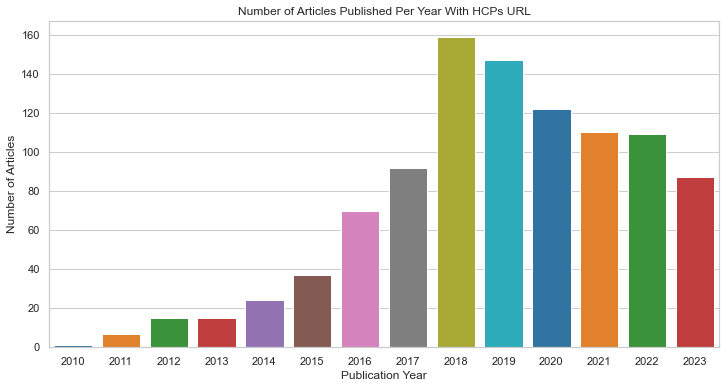

In [184]:
plt.figure(figsize=(12, 6))
sns.countplot(x='publication_year', data=selected_oa_hcp_df, palette=custom_palette)
plt.title('Number of Articles Published Per Year With HCPs URL')
plt.xlabel('Publication Year')
plt.ylabel('Number of Articles')
plt.savefig('../Results/graphics/HCPs_ArticlesPublishedPerYear.png')
plt.show()

The type of articles published that use a HCPs URL. 

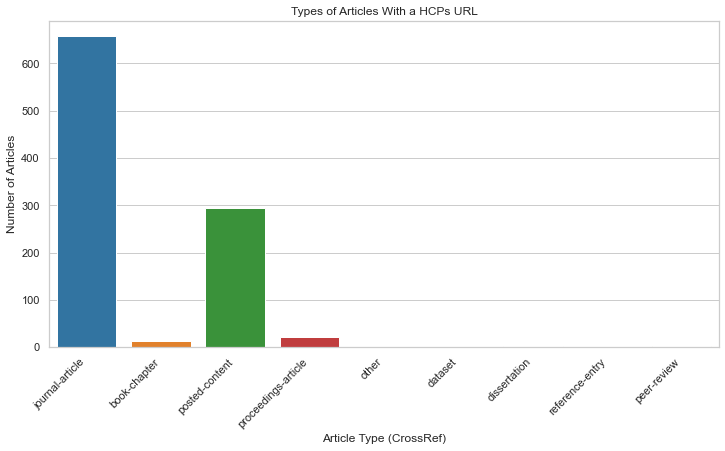

In [185]:
# Histogram for column 'type_crossref'
plt.figure(figsize=(12, 6))
sns.countplot(x='type_crossref', data=selected_oa_hcp_df, palette=custom_palette)
plt.title('Types of Articles With a HCPs URL')
plt.xlabel('Article Type (CrossRef)')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45, ha='right')  
plt.savefig('../Results/graphics/HCPs_ArticleTypes_crossref.png')
plt.show()

The journals that published articles that use a HCPs URL. 

In [187]:
journal_counts = selected_oa_hcp_df['display_name'].value_counts()
print(f"Number of unique journal names: {len(journal_counts)}")
print("\nJournal Name Counts:")
print(journal_counts)

Number of unique journal names: 214

Journal Name Counts:
bioRxiv (Cold Spring Harbor Laboratory)    233
NeuroImage                                  88
Human Brain Mapping                         46
Cerebral Cortex                             27
Scientific Reports                          27
                                          ... 
IEEE Signal Processing Magazine              1
Psychoneuroendocrinology                     1
Journal of Big Data                          1
Gut                                          1
Neuromethods                                 1
Name: display_name, Length: 214, dtype: int64


In [188]:
# Select the top 25 journals
top_journals = selected_oa_hcp_df['display_name'].value_counts().head(25)
top_journals

bioRxiv (Cold Spring Harbor Laboratory)    233
NeuroImage                                  88
Human Brain Mapping                         46
Cerebral Cortex                             27
Scientific Reports                          27
Nature Communications                       24
Research Square (Research Square)           23
The Journal of Neuroscience                 16
PLOS ONE                                    15
medRxiv (Cold Spring Harbor Laboratory)     14
Network neuroscience                        14
Communications biology                      13
Frontiers in Neuroscience                   11
Frontiers in Neuroinformatics               10
Brain Imaging and Behavior                   9
Brain                                        9
Operative Neurosurgery                       8
Magnetic Resonance in Medicine               8
Cortex                                       7
NeuroImage: Clinical                         7
eLife                                        7
Medical Image

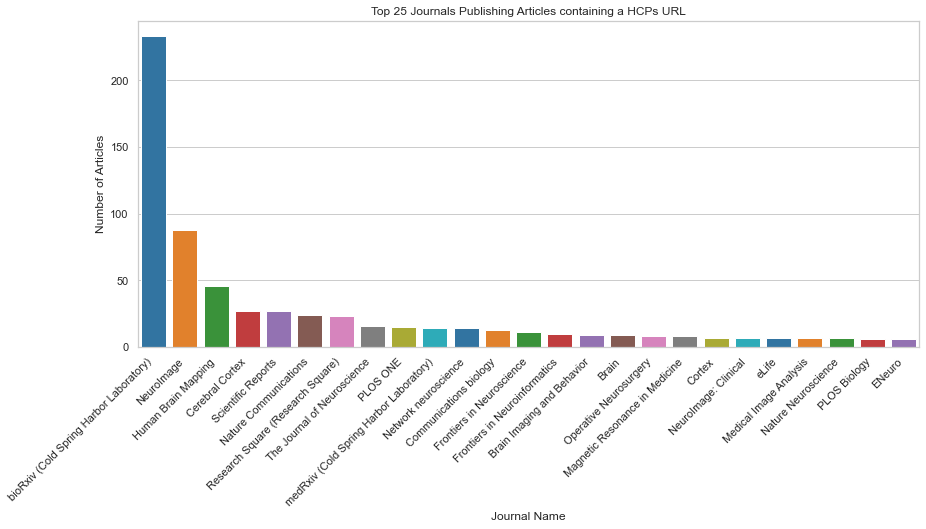

In [189]:
plt.figure(figsize=(14, 6))
sns.countplot(x='display_name', data=selected_oa_hcp_df, order=top_journals.index, palette=custom_palette)
plt.title('Top 25 Journals Publishing Articles containing a HCPs URL')
plt.xlabel('Journal Name')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45, ha='right')
plt.savefig('../Results/graphics/HCPs_Top25Journals.png')
plt.show()

How many times are articles that contain a HCPs URL cited? 

- Multiple boxplots using 'publication_year' and 'cited_by_count', so we can compare each year to see if there's a decrease or not in citations of the articles that use the HCP URLs

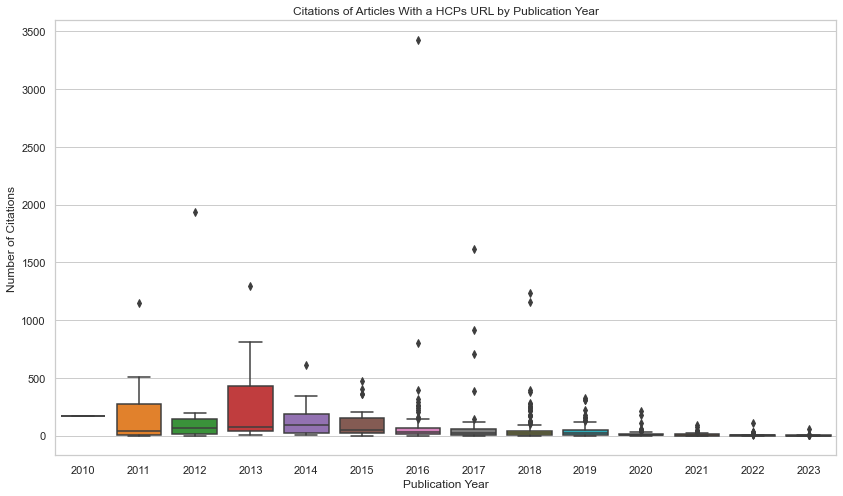

In [190]:
# Multiple boxplots using 'publication_year' and 'cited_by_count'
plt.figure(figsize=(14, 8))
sns.boxplot(x='publication_year', y='cited_by_count', data=selected_oa_hcp_df, palette=custom_palette)
plt.title('Citations of Articles With a HCPs URL by Publication Year')
plt.xlabel('Publication Year')
plt.ylabel('Number of Citations')
plt.savefig('../Results/graphics/HCPs_ArticlesCitationsByPublicationYear.png')
plt.show()

### Title 
In relation to the concept of data decay (), I was inspired by Szucs & Ioannidis (2020) to investigate the size of articles that contain statistical terms. 

In [ ]:
# Find the DOI of the articles that contain the HCP URLs 
# Read the articles - count how many contain any of the statistical terms 
# Put that into dataframe (raw count and percentage of articles with statistical terms out of all articles with the URL) 

In [71]:
print("Articles with material URLs: ", articles_with_material_url) 
print("Articles without material URLs: ", articles_without_material_url)

Articles with material URLs:  308
Articles without material URLs:  507


In [119]:
material_urls_list = material_urls['Material_URL']
hcp_urls # contains all the HCP urls 
HCPs # Material_URL, NeuroImage Articles, NeuroImage Articles W. Stats 

In [123]:
# Filter rows with material URLs 
material_rows = articles_df_unique[articles_df_unique['Clean URL'].isin(material_urls['Material_URL'])]

In [126]:
len(material_rows['DOI'].unique())

360

In [61]:
def fetch_results_with_statterms(url, session):
    """Fetch information about articles from OpenAlex API using pagination for a given URL, 
    if the article contains one (or more) specific terms defined by Szucs, D., & Ioannidis, J. PA. (2020). Sample size evolution in neuroimaging research: An evaluation of highly-cited studies (1990–2012) and of latest practices (2017–2018) in high-impact journals. NeuroImage, 221, 117164. https://doi.org/10.1016/j.neuroimage.2020.117164.

    Parameters: 
    - openalex_id(string):
    - statistical_terms(list):

    Return:
    - None
    """
    all_results = []
    processed_dois = set()
    url_prefixes = ['', 'https://', 'https://www.', 'http://', 'http://www.', 'www.']
    statistical_terms = ['ANOVA', 'ANCOVA', 't-test', 't test', 'p = ', 'p<', 'p>', 'p<=']

    for prefix in url_prefixes:
        current_url = f'{prefix}{url}'
        page = 1 
        cursor = "*"
        for term in statistical_terms: 
            while cursor is not None: 
                api_url = f'https://api.openalex.org/works?filter=fulltext.search:({current_url} AND {term})&per_page=50&cursor={cursor}'
                response = session.get(api_url)
                if response.status_code == 200:
                    data = response.json()
                    articles_on_page = data.get("results", [])
    
                    if not articles_on_page: 
                        break
                    
                    for result in articles_on_page:
                        doi = result.get('doi', '')
                        if doi in processed_dois:
                            continue
                        all_results.append(result)
                        processed_dois.add(doi)
                    
                    # Update the cursor for the next iteration
                    cursor = data.get("meta", {}).get("next_cursor")
                    
                    page += 1
                    time.sleep(0.1)  # Introduce a delay to comply with rate limits
                
                elif response.status_code == 403:
                    print("Error fetching data. Status code:", response.status_code)
                    print("Waiting and retrying...")
                    time.sleep(60)  # Wait for a minute before retrying
                
                else:
                    print("Error fetching data. Status code:", response.status_code)
                    if response.status_code == 429:
                        # Exponential backoff in case of rate limiting (status code 429)
                        delay = 2 ** (page - 1)
                        time.sleep(delay)
                        print(f"Retrying after {delay} seconds...")
                    else:
                        break

    # Save all_results to a single JSON file
    #combined_save_path = f'../Results/OpenAlexReuse/{url.replace("/", "_")}_unique.json'
    #with open(combined_save_path, 'w') as combined_json_file:
        #json.dump(all_results, combined_json_file, indent=2)
    return all_results

def process_material_urls_w_statterms(material_urls):
    """Process material URLs, fetches information about articles, and checks for statistical terms.
    """
    session = make_session()
    for material_url in material_urls:
        articles_info = fetch_results_with_statterms(material_url, session)
        
        if not articles_info:
            print(f"For material URL {material_url}: No articles found.")
            continue

        # Check statistical terms in each article and update the information
        #for article_info in articles_info:
            #contains_statistical_terms = check_statistical_terms(article_info['id'], session)
            #article_info['contains_statistical_terms'] = contains_statistical_terms
        
        # Save the information to a JSON file
        combined_save_path = f'../Results/HCPs/MaterialURLReuse_w_statterms/{material_url.replace("/", "_")}.json'
        with open(combined_save_path, 'w') as combined_json_file:
            json.dump(articles_info, combined_json_file, indent=2)

        # Calculate and print statistics
        print(f"For material URL {material_url}:")
        print(f"Number of articles: {len(articles_info)}")
        #print(f"Number of articles containing statistical terms: {sum(article['contains_statistical_terms'] for article in articles_info)}")
        print("=" * 50)

In [282]:
process_material_urls_w_statterms(hcp_urls)

For material URL humanconnectome.org:
Number of articles: 145
For material URL db.humanconnectome.org:
Number of articles: 27
For material URL humanconnectome.org/study/hcp-young-adult:
Number of articles: 54
For material URL humanconnectome.org/study/hcp-young-adult/document/1200-subjects-data-release:
Number of articles: 8
For material URL humanconnectome.org/study/hcp-young-adult/data-use-terms:
Number of articles: 30
For material URL protocols.humanconnectome.org/hcp/7t:
Number of articles: 3
For material URL wiki.humanconnectome.org/display/publicdata/how+to+connect+to+connectome+data+via+aws: No articles found.
For material URL humanconnectome.org/data:
Number of articles: 142
For material URL humanconnectome.org/disease-studies:
Number of articles: 68
For material URL humanconnectome.org/study/hcp-lifespan-aging:
Number of articles: 17
For material URL humanconnectome.org/study/hcp-lifespan-aging/data-releases:
Number of articles: 13
For material URL humanconnectome.org/study/hc

In [67]:
HCPs = pd.read_csv('../Results/HCPs/HCPs_urls.csv')
HCPs_urls = HCPs['Material_URL'].tolist()

json_directory_without_statterms = '../Results/HCPs/MaterialURLReuse/'
json_directory_with_statterms = '../Results/HCPs/MaterialURLReuse_w_statterms/'

data = {'URL': [], 'Total_Articles': [], 'Articles_With_Statterms': [], 'Percentage_With_Statterms': []}

# Iterate over each URL
for url in HCPs_urls:
    # Count for MaterialURLReuse folder
    json_file_path = os.path.join(json_directory_without_statterms, f'{url.replace("/", "_")}.json')
    if os.path.exists(json_file_path):
        json_df = pd.read_json(json_file_path)
        total_articles = len(json_df)
    else:
        total_articles = 0

    # Count for MaterialURLReuse_w_statterms folder
    json_file_path_with_statterms = os.path.join(json_directory_with_statterms, f'{url.replace("/", "_")}.json')
    if os.path.exists(json_file_path_with_statterms):
        json_df_with_statterms = pd.read_json(json_file_path_with_statterms)
        articles_with_statterms = len(json_df_with_statterms)
    else:
        articles_with_statterms = 0

    # Calculate percentage distribution
    percentage_with_statterms = (articles_with_statterms / total_articles) * 100 if total_articles != 0 else 0

    # Update the data dictionary
    data['URL'].append(url)
    data['Total_Articles'].append(total_articles)
    data['Articles_With_Statterms'].append(articles_with_statterms)
    data['Percentage_With_Statterms'].append(round(percentage_with_statterms, 2))

# Create a DataFrame
result_df = pd.DataFrame(data)

In [68]:
# Print or use the results as needed
print("Percentage distribution per URL:")
result_df

Percentage distribution per URL:


,URL,Total_Articles,Articles_With_Statterms,Percentage_With_Statterms
0,humanconnectome.org,847,145,17.12
1,db.humanconnectome.org,200,27,13.50
2,humanconnectome.org/study/hcp-young-adult,270,54,20.00
3,humanconnectome.org/study/hcp-young-adult/docu...,42,8,19.05
4,humanconnectome.org/study/hcp-young-adult/data...,134,30,22.39
5,protocols.humanconnectome.org/hcp/7t,5,3,60.00
6,wiki.humanconnectome.org/display/publicdata/ho...,0,0,0.00
7,humanconnectome.org/data,804,142,17.66
8,humanconnectome.org/disease-studies,428,68,15.89
9,humanconnectome.org/study/hcp-lifespan-aging,88,17,19.32


In [64]:
print("\nOverall percentage distribution:")
print(f"{overall_percentage_distribution:.2f}%")


Overall percentage distribution:
18.17%


<a name='references'></a>
# References
- Hunter, J. D. (2007). Matplotlib: A 2D Graphics Environment. Computing in Science & Engineering, 9(3), 90–95. https://doi.org/10.1109/MCSE.2007.55
- OpenAlexAPI. (n.d.-a). Filter works. OpenAlex API Documentation. Retrieved September 14, 2023, from https://docs.openalex.org/api-entities/works/filter-works
- OpenAlexAPI. (n.d.-b). Search Works. Retrieved November 23, 2023, from https://docs.openalex.org/api-entities/works/search-works
- OpenAlexAPI. (n.d.-c). Work object. OpenAlex API Documentation. Retrieved September 17, 2023, from https://docs.openalex.org/api-entities/works/work-object#is_paratext
- Priem, J., Piwowar, H., & Orr, R. (2022). OpenAlex: A fully-open index of scholarly works, authors, venues, institutions, and concepts. ArXiv. https://arxiv.org/abs/2205.01833
- Sourget, T. (2023a). Public_Medical_Datasets_References [Jupyter Notebook]. https://github.com/TheoSourget/Public_Medical_Datasets_References (Original work published 2023)
- Sourget, T. (2023b). TheoSourget/DDSA_Sourget: Repository used during my travel at the ITU of Copenhagen in March 2023 [Computer software]. https://github.com/TheoSourget/DDSA_Sourget
- Szucs, D., & Ioannidis, J. PA. (2020). Sample size evolution in neuroimaging research: An evaluation of highly-cited studies (1990–2012) and of latest practices (2017–2018) in high-impact journals. NeuroImage, 221, 117164. https://doi.org/10.1016/j.neuroimage.2020.117164
- Waskom, M. L. (2021). seaborn: Statistical data visualization. Journal of Open Source Software, 6(60), 3021. https://doi.org/10.21105/joss.03021

---

In [ ]:
def find_root_and_derivatives(urls):
    """ 
    This function performs some initial cleaning of the URLs, removing the beginning (https:// or wwww) and puts all text into lowercase. 
    Parameters: 
    :param urls(list): Sorted list of unique URLs from a dataframe
    """    
    # Remove "https://", "http://", and "www." from the URLs
    clean_urls = [url.replace("https://", "").replace("http://", "").replace("www.", "").lower() for url in urls]
    
    url_dict = {}
    for url in clean_urls:
        root = url.split('/')[0]
        # root = '/'.join(url.split('/'))
        if root in url_dict:
            url_dict[root].append(url)
        else:
            url_dict[root] = [url]

    grouped_df = pd.DataFrame(url_dict.items(), columns=['Root', 'Derivatives']).sort_values('Root', ascending=True)

    return grouped_df

test = find_root_and_derivatives(material_urls['Material_URL'])